# RFM Analysis on Online Retail Dataset (UCI)

This notebook performs a **Recency-Frequency-Monetary (RFM) analysis** on the Online Retail dataset (UCI).
RFM analysis is a marketing technique used to segment customers based on their purchasing behavior:

- **Recency (R):** How recently a customer made a purchase  
- **Frequency (F):** How often a customer makes a purchase  
- **Monetary (M):** How much money a customer spends  

The analysis will help identify customer segments such as **Champions, Loyal Customers, Potential Loyalists, and At Risk customers**, along with suggested marketing actions.

---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
sns.set(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (10,6)


## Load and Prepare Dataset

In [ ]:
# Dataset: Online Retail (UCI repository)
df = pd.read_excel("online_retail/data.xlsx")

# Remove missing Customer IDs and cancellations
df = df[df['CustomerID'].notnull()]
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Create total price column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Calculate RFM Values

In [3]:
# Analysis date (1 day after last invoice)
analysis_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by customer and calculate metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.columns = ['Recency','Frequency','Monetary']
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


## Assign RFM Scores

In [4]:
# Recency: lower = better (5 is most recent)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)

# Frequency: higher = better
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

# Monetary: higher = better
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# RFM segment and score
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)
rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7
12347.0,2,7,4310.00,5,5,5,555,15
12348.0,75,4,1797.24,2,4,4,244,10
12349.0,19,1,1757.55,4,1,4,414,9
12350.0,310,1,334.40,1,1,2,112,4


## Segment Customers

In [5]:
def rfm_group(x):
    if x >= 12:
        return "Champions"
    elif x >= 9:
        return "Loyal Customers"
    elif x >= 6:
        return "Potential Loyalists"
    else:
        return "At Risk"

rfm['Segment'] = rfm['RFM_Score'].apply(rfm_group)
rfm.head()


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segment
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7,Potential Loyalists
12347.0,2,7,4310.00,5,5,5,555,15,Champions
12348.0,75,4,1797.24,2,4,4,244,10,Loyal Customers
12349.0,19,1,1757.55,4,1,4,414,9,Loyal Customers
12350.0,310,1,334.40,1,1,2,112,4,At Risk


## Visualize Segments

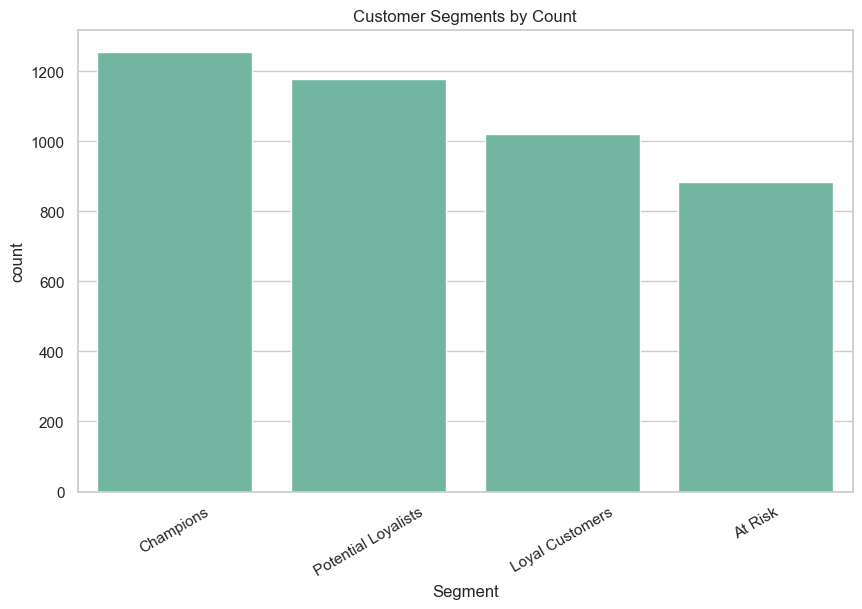

In [6]:
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title("Customer Segments by Count")
plt.xticks(rotation=30)
plt.show()


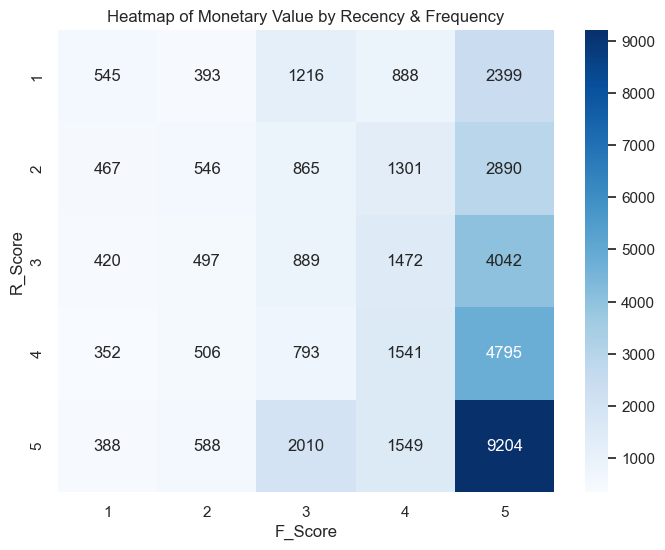

In [ ]:
# Compute mean Monetary value by R and F scores
rfm_heatmap = rfm.groupby(['R_Score','F_Score'])['Monetary'].mean().unstack()
plt.figure(figsize=(8,6))
sns.heatmap(rfm_heatmap, annot=True, fmt=".0f", cmap="Blues")
plt.title("Heatmap of Monetary Value by Recency & Frequency")
plt.show()


## Marketing Insights

- **Champions**: Offer exclusive discounts, early product launches, VIP programs  
- **Loyal Customers**: Build loyalty programs, personalized recommendations  
- **Potential Loyalists**: Send coupons to encourage repeat purchases  
- **At Risk**: Re-engage with surveys, win-back offers, or reminders  

---
